In [1]:
import ScatteredInterpolation
import DelimitedFiles
using Plots

In [2]:
fpath = "../res/realgas/aqua_eos_pt_v1_0.dat"

# Read the file
println("Reading AQUA table at '$fpath'")
data::Array{Float64,2} = DelimitedFiles.readdlm(fpath, Float64; header=false, skipstart=19)

# Parse the columns as 1D arrays
#    input
a1_prs::Array{Float64} = data[:,1]
a1_tmp::Array{Float64} = data[:,2]
#    output
a1_rho::Array{Float64} = data[:,3]
a1_gad::Array{Float64} = data[:,4]
a1_mmw::Array{Float64} = data[:,8]
a1_phs::Array{Int}     = Int.(data[:,11])

# Define phases
phases = Dict{Integer,String}(-1=>"ice-Ih", -2=>"ice-II",-3=>"ice-III", -5=>"ice-V", -6=>"ice-VI", -7=>"ice-VII", -10=>"ice-X",
                                3=>"vapor", 4=>"liquid", 5=>"supercritical+superionic")

Reading AQUA table at '../res/realgas/aqua_eos_pt_v1_0.dat'


Dict{Integer, String} with 10 entries:
  5   => "supercritical+superionic"
  4   => "liquid"
  -5  => "ice-V"
  -1  => "ice-Ih"
  -10 => "ice-X"
  -7  => "ice-VII"
  -3  => "ice-III"
  -2  => "ice-II"
  -6  => "ice-VI"
  3   => "vapor"

In [3]:
# Dimensions are hardcoded inside the file
npts_prs = length(unique(a1_prs))
npts_tmp = length(unique(a1_tmp))

println("Pressure axis:    $npts_prs points")
println("Temperature axis: $npts_tmp points")

Pressure axis:    1093 points
Temperature axis: 301 points


In [4]:
# Reshape arrays into 2D
a2_prs = reshape(a1_prs, (npts_tmp,npts_prs))
a2_tmp = reshape(a1_tmp, (npts_tmp,npts_prs))

a2_rho = reshape(a1_rho, (npts_tmp,npts_prs))
a2_gad = reshape(a1_gad, (npts_tmp,npts_prs))
a2_mmw = reshape(a1_mmw, (npts_tmp,npts_prs))


301×1093 Matrix{Float64}:
 0.0180153   0.0180153   0.0180153   …  0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153   …  0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 0.0180153   0.0180153   0.0180153      0.0180153  0.0180153  0.0180153
 ⋮                                   ⋱  ⋮                     
 0.00300255  0.00300255  0.00300255     0.0180153  0.0180153  0.0180153
 0.00300255  0.00300255  0.00300255     0.0180153  0.0180153  0.0180153
 0.00300255  0.00300255  0.00300255     0.01801

In [5]:
# Get pressure, temperature axes
ax_prs = a2_prs[1,:]
ax_tmp = a2_tmp[:,1]

301-element Vector{Float64}:
    100.0
    102.329299
    104.712855
    107.151931
    109.64782
    112.201845
    114.815362
    117.489755
    120.226443
    123.026877
      ⋮
  83176.3771
  85113.8038
  87096.359
  89125.0938
  91201.0839
  93325.4301
  95499.2586
  97723.7221
 100000.0

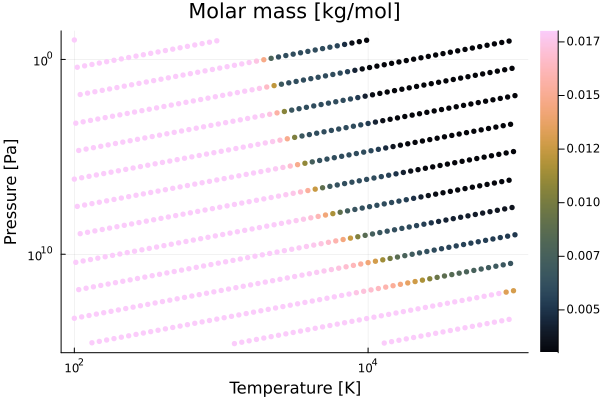

In [6]:
stride = 500

plt = plot(title="Molar mass [kg/mol]", xlabel="Temperature [K]", xscale=:log10, ylabel="Pressure [Pa]", yscale=:log10, yflip=true)
scatter!(plt, a1_tmp[1:stride:end], a1_prs[1:stride:end], marker_z = a1_mmw[1:stride:end],
            label="", ms=3, msw=0, cmap=:batlowK)
display(plt)

In [7]:
# Array to interpolate
a1_val = a1_mmw

# Create interpolators
eval_pts = vcat(a1_tmp', a1_prs')
itp_val = ScatteredInterpolation.interpolate(ScatteredInterpolation.NearestNeighbor(), eval_pts, a1_val)

ScatteredInterpolation.NearestNeighborInterpolant{Float64, NearestNeighbors.KDTree{StaticArraysCore.SVector{2, Float64}, Distances.Euclidean, Float64, StaticArraysCore.SVector{2, Float64}}}([0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268  …  0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268, 0.018015268], NearestNeighbors.KDTree{StaticArraysCore.SVector{2, Float64}, Distances.Euclidean, Float64, StaticArraysCore.SVector{2, Float64}}
  Number of points: 328993
  Dimensions: 2
  Metric: Distances.Euclidean(0.0)
  Reordered: true)

In [12]:
samples = 700  # for sampling the interpolator

eval_tmp = 10.0 .^ range(log10(a1_tmp[1]),log10(a1_tmp[end]),length=samples)
eval_prs = 10.0 .^ range(log10(a1_prs[1]),log10(a1_prs[end]),length=samples)

i2_val = zeros(Float64, (samples,samples))
i2_tmp = zeros(Float64, (samples,samples))
i2_prs = zeros(Float64, (samples,samples))

for (i,t) in enumerate(eval_tmp)
    for (j,p) in enumerate(eval_prs)

        i2_tmp[i,j] = t
        i2_prs[i,j] = p
        i2_val[i,j] = ScatteredInterpolation.evaluate(itp_val, [t,p])[1]

    end
end

i1_val = reshape(i2_val,(samples*samples))
i1_tmp = reshape(i2_tmp,(samples*samples))
i1_prs = reshape(i2_prs,(samples*samples))
;

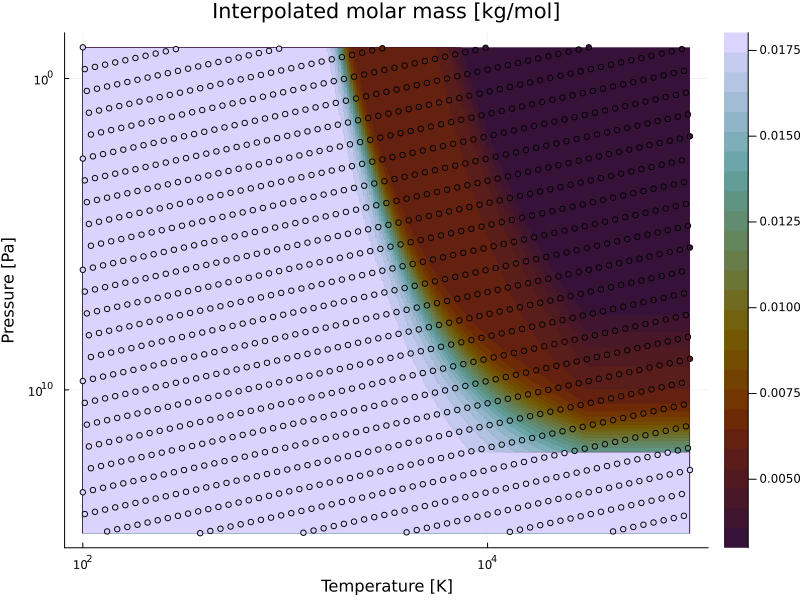

In [13]:
stride  = 250   # for scatter plot

plt = plot(title="Interpolated molar mass [kg/mol]", xlabel="Temperature [K]", xscale=:log10, ylabel="Pressure [Pa]", yscale=:log10, yflip=true, size=(800,600))

contourf!(plt, eval_tmp, eval_prs, i2_val', label="", cmap=:glasgow, lw=0, levels=25)

scatter!(plt, a1_tmp[1:stride:end], a1_prs[1:stride:end], marker_z=a1_val[1:stride:end], label="", ms=3, msw=0.8, msc=:black, cmap=:glasgow)

display(plt)